In [1]:
import config
from config import load_ml_data


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from pprint import pprint

import statsmodels.api as sm
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn import model_selection
from sklearn.model_selection import cross_val_score

{'calculate': {'analysis': True,
               'friends': False,
               'network': True,
               'uniquetweets': True,
               'uniqueusers': True},
 'data': {'dates': ['2018-03-11', '2018-03-12', '2018-03-13'],
          'eventname': "Givenchy's Death",
          'phrases': ['givenchy%20death', 'givenchy%20passed%20away'],
          'starttime': 'Mar 12 08:20:00 -0500 2018'},
 'path': {'cwd': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy',
          'ml': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle',
          'networkx': {'all': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle/networkx_all.dat',
                       'friends': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle/networkx_friends.dat',
                       'potential': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle/networkx_potential.dat'},
          'newcrawl': '/Users/lzhou/git/github/uclresearchanalysis/ot

/Users/lzhou/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/lzhou/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [3]:
def run_logistic_regression_for_interval(interval):
    data = load_ml_data(interval)
    data = data.reset_index(drop=True)
    data['label'].value_counts()
    sns.countplot(x = 'label', data = data, palette = 'hls')
    plt.show()
    
    # Feature selection using Recursive Feature Elimination
    x_col = ['kIn', 'kOut-1', 'kOut0', 'kOutAverage', 'kOutMax', 'kOutMin',
       'nNodes', 't-1', 't0', 'tAverage', 'tCurrent']
    y_col = ['label']
    X = data[x_col]
    X = X.astype('float')
    y = data[y_col]
    y = y.astype('int').values.ravel()
    logreg = LogisticRegression()
    rfe = RFE(logreg, 1)
    rfe = rfe.fit(X, y)
    pprint(sorted(list(zip(rfe.ranking_, x_col))))
    
    
    
    x_col = [y for x, y in list(zip(rfe.ranking_, x_col))]
    print(x_col)
    y_col = ['label']
    X = data[x_col]
    X = X.astype('float')
    Y = data[y_col]
    y = Y.astype('int').values.ravel()
    
    

    stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
    logit_model=sm.Logit(y,X)
    result=logit_model.fit()
    print(result.summary())


    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    
    y_train = Y_train.astype('int').values.ravel()
    y_test = Y_test.astype('int').values.ravel()
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, y_test)))
    
    interval_time = []
    interval_accuracy = []
    for i in range(interval, 24 * 60, interval):
        val1 = data[data.tCurrent == i].index
        val2 = X_test.index
        indexes = [val for val in val1 if val in val2]
        
        X_interval = X_test.loc[indexes]
        y_interval = Y_test.loc[indexes].astype('int').values.ravel()
        interval_time.append(i)
        interval_accuracy.append(logreg.score(X_interval, y_interval))
        
    interval_accuracy_df = pd.DataFrame(data = {
        'time_lapsed': interval_time, 
        'accuracy': interval_accuracy
    })
    plt.figure()
    ax = sns.barplot(x="time_lapsed", y="accuracy", data=interval_accuracy_df)
    plt.xticks(rotation=90)
    plt.show()

    kfold = model_selection.KFold(n_splits=10, random_state=7)
    modelCV = LogisticRegression()
    scoring = 'accuracy'
    results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
    print("10-fold cross validation average accuracy: %.5f" % (results.mean()))
    
    cm = confusion_matrix(y_test, y_pred)
    
    print_cm(cm, ['Not Infected', 'Infected'])

    logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

Loading data file from path /Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle/60_data.dat
'Loaded 111378 entires'


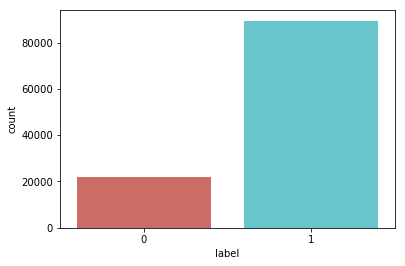

[(1, 'nNodes'),
 (2, 'kIn'),
 (3, 't0'),
 (4, 'tAverage'),
 (5, 't-1'),
 (6, 'tCurrent'),
 (7, 'kOutAverage'),
 (8, 'kOutMax'),
 (9, 'kOutMin'),
 (10, 'kOut0'),
 (11, 'kOut-1')]
['kIn', 'kOut-1', 'kOut0', 'kOutAverage', 'kOutMax', 'kOutMin', 'nNodes', 't-1', 't0', 'tAverage', 'tCurrent']
Optimization terminated successfully.
         Current function value: 0.346062
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               111378
Model:                          Logit   Df Residuals:                   111367
Method:                           MLE   Df Model:                           10
Date:                Tue, 19 Jun 2018   Pseudo R-squ.:                  0.3030
Time:                        01:14:16   Log-Likelihood:                -38544.
converged:                       True   LL-Null:                       -55302.
                                        LLR p-value:    

NameError: name 'pd' is not defined

In [4]:
run_logistic_regression_for_interval(60)

In [ ]:
run_logistic_regression_for_interval(30)

In [ ]:
run_logistic_regression_for_interval(15)

In [ ]:
run_logistic_regression_for_interval(7)